In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from statsmodels.stats.multitest import multipletests

from tqdm.notebook import trange

In [2]:
%matplotlib inline
%load_ext watermark

In [3]:
# set a fixed random state for reproduceability random state from random.org
import random
random.seed(0x39d6462a)
#np.random.seed(random.randint(0, 0x1<<31))
cgbsa_rand_seed = random.getrandbits(30)
cgbsa_tts_rand_seed = random.getrandbits(30)
bootstrap_rand_seed = random.getrandbits(30)

In [4]:
expression_data = pd.read_csv('../data/GSE58812.csv.xz')
expression_data['death'] = expression_data['death'].astype(bool)

In [5]:
feature_names = ['RETN', 'HIP1R', 'DDX51', 'CCL4L1', 'XRCC6P5', 'LRRC37A2', 'PWP2',
   'CROCCP2', 'CRHR1', 'ELMO3', 'PRKY', 'FLJ26850', 'KIAA1324L', 'ZFP64',
   'SNORA76C', 'DHRS4-AS1', 'C19ORF52', 'PPIL3', 'KLK10', 'ASH1L-AS1',
   'GUSBP3', 'GPR17', 'SAXO1', 'IQCK', 'DNASE1L1', 'ZNF65', 'HEXIM1',
   'FOXQ1'
]
print('missing genes', *[f for f in feature_names if f not in expression_data.columns])

missing genes CCL4L1 XRCC6P5 C19ORF52 SAXO1 ZNF65


In [6]:
metadata = ['age-at-diag','death','over-all-survival','event-free-survival']
genes = [f for f in feature_names if f in expression_data.columns]
print(expression_data['death'].value_counts())
expression_data[metadata + genes].describe()

False    78
True     29
Name: death, dtype: int64


,age-at-diag,over-all-survival,event-free-survival,RETN,HIP1R,DDX51,LRRC37A2,PWP2,CROCCP2,CRHR1,...,DHRS4-AS1,PPIL3,KLK10,ASH1L-AS1,GUSBP3,GPR17,IQCK,DNASE1L1,HEXIM1,FOXQ1
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,56.965387,2202.635514,2116.028037,52.385707,692.722859,6.974726,23.961849,874.514868,1848.374150,53.244019,...,1069.047099,1762.979088,45.555090,691.215300,324.110491,8.461317,143.887321,707.240714,579.123405,793.824657
std,12.800894,1251.161607,1322.561547,27.444842,333.775303,6.553985,18.833741,407.501972,734.457494,57.398382,...,470.954495,549.745437,50.577921,489.496189,384.908714,12.952957,69.939981,300.349072,271.138916,1182.118598
min,28.481860,20.000000,20.000000,7.543103,226.982700,2.362775,1.871591,236.703200,522.240500,5.563745,...,444.769500,635.420600,1.544445,288.336700,4.202932,1.377574,37.433550,254.360600,171.911600,40.143510
25%,49.348395,1271.500000,1000.500000,30.730280,478.261200,3.259261,7.652034,627.985850,1338.845500,22.213155,...,772.356800,1431.465500,14.598730,415.956400,148.341650,3.039130,101.930400,523.068000,390.238950,188.172050
50%,57.341550,2032.000000,2025.000000,50.856710,627.614000,4.565337,18.229120,784.242200,1622.243000,41.287680,...,973.399300,1692.144000,32.490650,548.564100,217.638700,4.573975,132.648100,659.098900,509.621800,373.325500
75%,66.338125,2996.000000,2996.000000,71.021455,790.891600,7.493795,35.621830,1031.834500,2254.174500,66.828520,...,1246.095500,2088.094000,56.039330,825.024450,316.103350,8.223022,162.006800,835.222200,749.288200,867.007700
max,84.632450,5150.000000,5150.000000,121.916600,2102.349000,37.574200,80.581300,2604.663000,4995.789000,506.121300,...,3374.366000,3384.072000,347.257300,3881.378000,2680.327000,114.166200,408.410400,1921.561000,1678.792000,7036.018000


In [7]:
survival_data = pd.DataFrame.from_records(
    [compare_survival(
        expression_data[['death', 'over-all-survival']].to_records(index=False),
        expression_data[gene] > expression_data[gene].median()
    )
     for gene in genes],
    columns=['chi-square','p-value'],
    index=genes
)
survival_data.sort_values('p-value', inplace=True)
fdr_correction = multipletests(survival_data['p-value'], method='fdr_tsbky')
survival_data['FDR'] = fdr_correction[1]
survival_data['reject'] = fdr_correction[0]
survival_data

,chi-square,p-value,FDR,reject
PPIL3,4.939019,0.026257,0.634105,False
ELMO3,3.468506,0.062548,0.665608,False
ZFP64,2.797410,0.094417,0.665608,False
HIP1R,2.550696,0.110246,0.665608,False
KIAA1324L,1.925569,0.165244,0.798128,False
DHRS4-AS1,1.338991,0.247212,0.955859,False
DDX51,1.136329,0.286429,0.955859,False
IQCK,0.813579,0.367064,0.955859,False
GUSBP3,0.614399,0.433136,0.955859,False
SNORA76C,0.364438,0.546052,0.955859,False


In [8]:
X,y = (expression_data[['age-at-diag'] + genes],
    expression_data[['death', 'over-all-survival']].to_records(index=False))
est_cph = make_pipeline(
    StandardScaler(),
    CoxPHSurvivalAnalysis(
        ties='efron',
        alpha=0
    )
)
est_cph.fit(X, y)
print(est_cph.score(X,y))
pd.DataFrame(
    est_cph.named_steps.coxphsurvivalanalysis.coef_,
    index=X.columns
).sort_values(0, ascending=False)

0.7707493956486704


,0
age-at-diag,0.918333
ELMO3,0.387805
CRHR1,0.358125
LRRC37A2,0.352482
HEXIM1,0.298703
IQCK,0.291034
CROCCP2,0.271286
HIP1R,0.228673
DHRS4-AS1,0.227451
RETN,0.199435


In [9]:
rand_state = np.random.RandomState(seed=bootstrap_rand_seed)
test_clf = make_pipeline(
    StandardScaler(),
    CoxPHSurvivalAnalysis(
        ties='efron',
        alpha=0
    )
)

X,y = (expression_data[['age-at-diag'] + genes],
    expression_data[['death', 'over-all-survival']].to_records(index=False))

replicates = []
for _ in trange(500, leave=False):
    feature_X_train, feature_X_test, y_train, y_test = train_test_split(
        X, y,
        random_state=rand_state
    )

    test_clf.fit(feature_X_train, y_train)
    replicates.append(test_clf.named_steps.coxphsurvivalanalysis.coef_)

  0%|          | 0/500 [00:00<?, ?it/s]

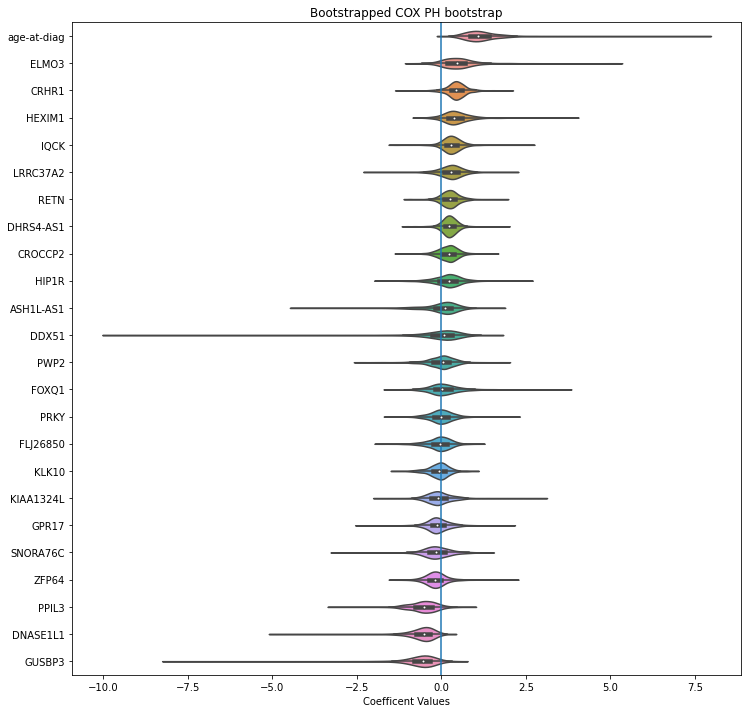

In [10]:
coef_data = pd.DataFrame(
  np.row_stack(replicates),
  columns=X.columns
)

plt.figure(figsize=(12,12))
plt.title('Bootstrapped COX PH bootstrap')
plt.xlabel('Coefficent Values')
sns.violinplot(
    data=coef_data,
    orient='h',
    order=list(coef_data.median(axis=0).sort_values(ascending=False).index)
)
plt.axvline(0)
#plt.savefig('../figures/bootstrap-shap-importance.eps')
plt.show()

In [11]:
%watermark \
--python \
--packages pandas,sklearn,sksurv,matplotlib,seaborn,statsmodels \
--date --updated

Last updated: 2022-03-09

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 7.31.1

pandas     : 1.3.5
sklearn    : 1.0.2
sksurv     : 0.0.0
matplotlib : 3.5.0
seaborn    : 0.11.2
statsmodels: 0.13.2

